# Vyhodnocovanie zhlukov
- Nevieme zhluky vyhodnotiť presne (neexistuje ground-truth)
- Existujú len metriky ktoré nám vedia povedať rozdiely medzi zhlukami.
- Snažíme sa vyhodnotiť podobnosť (či Metallica nie je v clusteri s Kolarovcami) na základe čŕt skupiny.
- Podobnosť = vzdialenosť bodu A - vzdialenosť bodu B

In [4]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 

In [5]:
raw_data = loadarff('data/complex9.arff')
df1 = pd.DataFrame(raw_data[0])

In [6]:
df1.head()

,x,y,class
0,660.976,304.225,b'0'
1,636.213,306.174,b'0'
2,662.753,307.565,b'0'
3,657.487,307.740,b'0'
4,635.273,308.157,b'0'


In [7]:
def visualize_clusters(df,x,y, cluster_id):
    ax1 = plt.axes()
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i in range(0,9):
        ax1.scatter(
            df[x][df[cluster_id].astype('int') == i], 
            df[y][df[cluster_id].astype('int') == i], 
            alpha=1, c=colors[i],
            s=3, 
            label=i)
    ax1.scatter(
            df[x][df[cluster_id].astype('int') > 9], 
            df[y][df[cluster_id].astype('int') > 9], 
            alpha=1, c='black',
            s=3, 
            label=i)


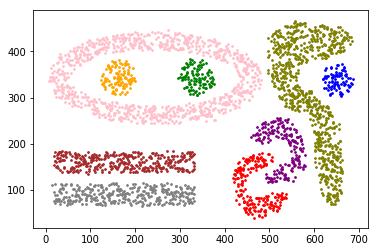

In [5]:
visualize_clusters(df1, 'x', 'y', 'class')

In [10]:
train_df1 = df1[['x','y']]

# K-Means visualization

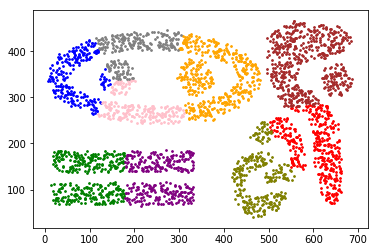

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(train_df1)
df1['k_means_predicted'] = kmeans.labels_
visualize_clusters(df1, 'x', 'y', 'k_means_predicted')

# DBScan visualization

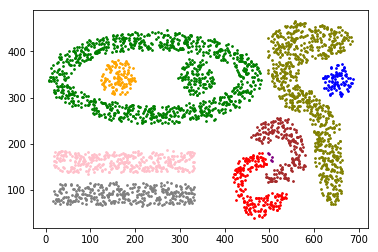

In [8]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=13, min_samples=5).fit(train_df1)
df1['db_scan_predicted'] = dbscan.labels_
visualize_clusters(df1, 'x', 'y', 'db_scan_predicted')

# Meanshift visualization

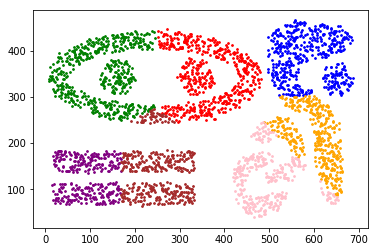

In [9]:
from sklearn.cluster import MeanShift

meanshift = MeanShift(bandwidth=100).fit(train_df1)
df1['mean_shift_predicted'] = meanshift.labels_
visualize_clusters(df1, 'x','y', 'mean_shift_predicted')

In [10]:
from sklearn import metrics
k_means = np.array(df1['k_means_predicted'])
db_scan = np.array(df1['db_scan_predicted'])
meanshift = np.array(df1['mean_shift_predicted'])

In [11]:
def visualize_metrics(array, label):
    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    plt.bar(r1, array, color=['#7f6d5f', '#557f2d', '#2d7f5e'], width=barWidth, edgecolor='white', label=label)
    plt.xticks([r for r in range(len(bars1))], ['K-Means', 'DBSCAN', 'MeanShift'])

    # Create legend & Show graphic
    plt.legend()
    plt.show()

---

# Metriky vyhodnocovania

# K-Means
----

### Elbow metóda
- Najdenie najlepisej hodnoty k pre k-means.
- Urobi to suctom^2 vzdialenosti bodov od kusteru.

#### Inertia: Sum of distances of samples to their closest cluster center

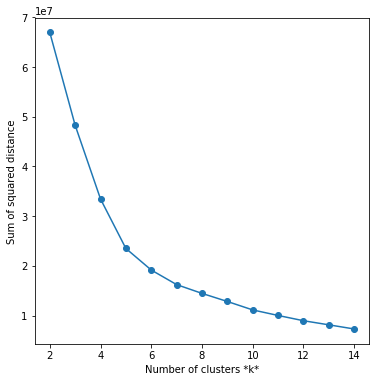

In [12]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(2, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(train_df1)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Gap Statistic

In [13]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    

In [14]:
k, gapdf = optimalK(train_df1)
print('Optimal k is: ' + str(k))

Optimal k is: 14


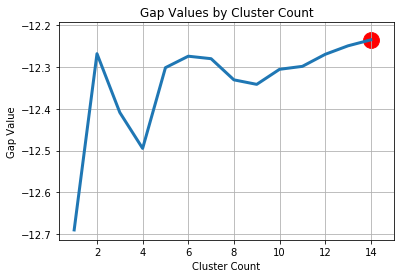

In [15]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount,
            gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

### Calinski criterion
- Vacsia hodnota tohto criteria, znamena model z lepsimi zhlukmi
- Pomer medzi rozlozenim prvkov v danom clusteri a medzi nimi

- Looking at the definition for the Calinski-Harabasz score, it's apparent that it works best on "globular" clustering algorithms, because it rewards clusterings in which the cluster centroids are far apart and the cluster members are close to their respective centroids

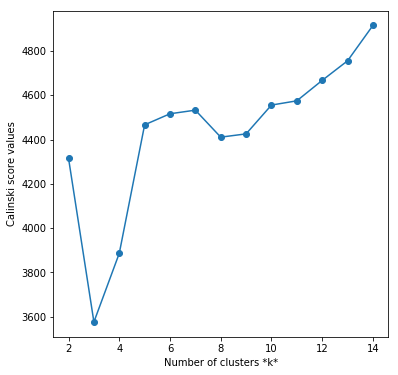

In [16]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans

calinski = []
list_k = list(range(2, 15))

for k in list_k:
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(train_df1)
    labels = kmeans_model.labels_
    
    calinski.append(metrics.calinski_harabaz_score(train_df1, labels))
    
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, calinski, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Calinski score values');

### Silhouette koeficient
Vyhodnocuje sa ako dobre je každý jednotlivec clusteru priradený doňho zaradený.

+ a(i) - priemerná vzdialenosť bodu i od všetkych bodov klusteru do ktorého patrí bod i.
+ b(i) - je najmenší priemer vzdialenosti bodu i ku každému bodu v iných clusteroch. Robí sa to tak že zoberieme urobíme priemer bodu i ku každému bodu v clusteri A, potom clusteri B a ich výsledky porovnáme.

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [18]:
def plot_silhouette_coefficient():
    for i, k in enumerate([2, 4, 6, 7, 8, 10, 14]):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12, 6)

        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(train_df1)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(train_df1, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)

            color = cm.nipy_spectral(float(i) / k)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, color=color, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)

        print("Priemer silhouette-ho koeficientu pri k=" + str(k) + " je " + str(avg_score))

        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02);

        colors = cm.nipy_spectral(labels.astype(float) / k)
        ax2.scatter(train_df1.iloc[:, 0], train_df1.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Draw white circles at cluster centers
        ax2.scatter(centroids[:, 0], centroids[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centroids):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.tight_layout()
        plt.suptitle(f'Silhouette analysis using k = {k}',
                     fontsize=16, fontweight='semibold', y=1.05);

Priemer silhouette-ho koeficientu pri k=2 je 0.49436558947261616
Priemer silhouette-ho koeficientu pri k=4 je 0.4285571386629913
Priemer silhouette-ho koeficientu pri k=6 je 0.4559858674559058
Priemer silhouette-ho koeficientu pri k=7 je 0.4436762966294066
Priemer silhouette-ho koeficientu pri k=8 je 0.41827066708119315
Priemer silhouette-ho koeficientu pri k=10 je 0.4271843705746988
Priemer silhouette-ho koeficientu pri k=14 je 0.41897119047094156


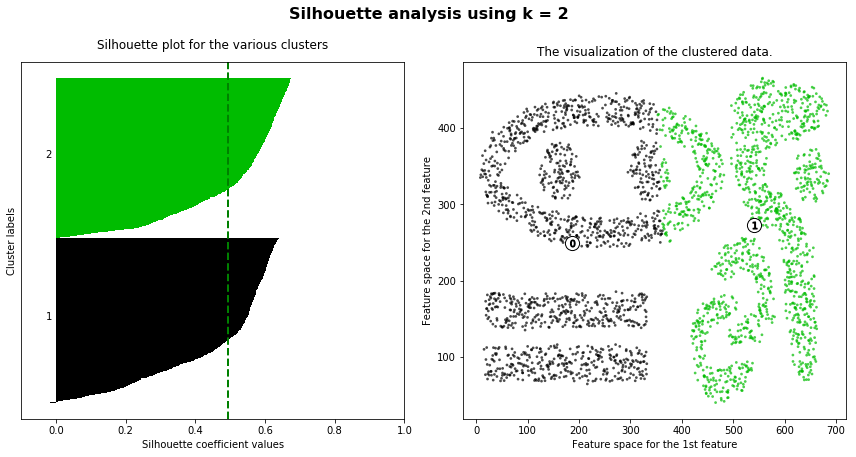

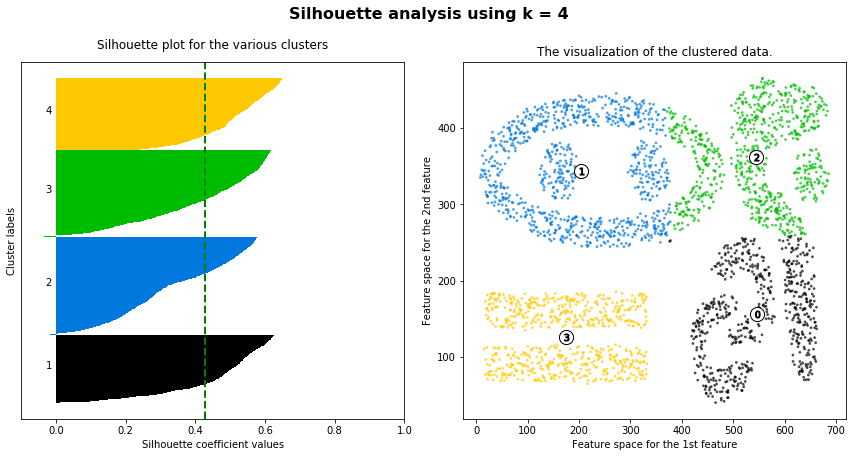

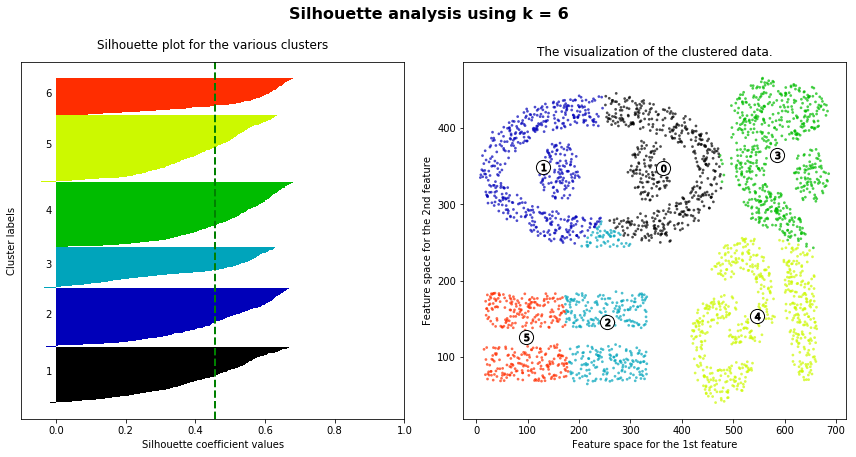

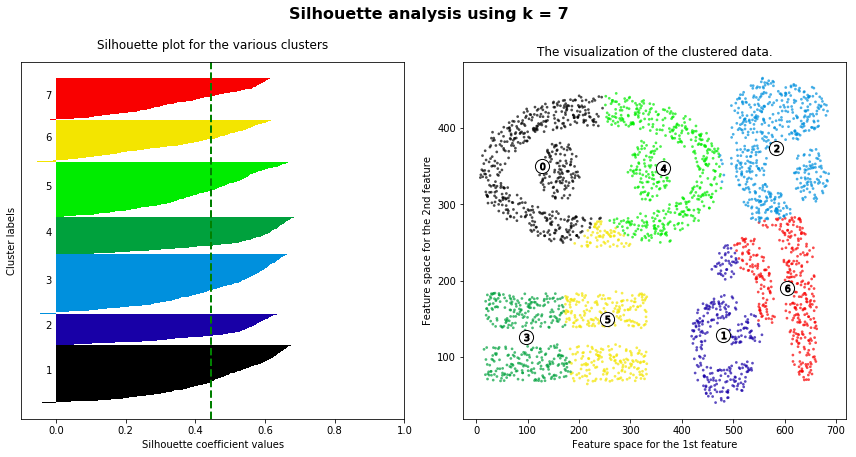

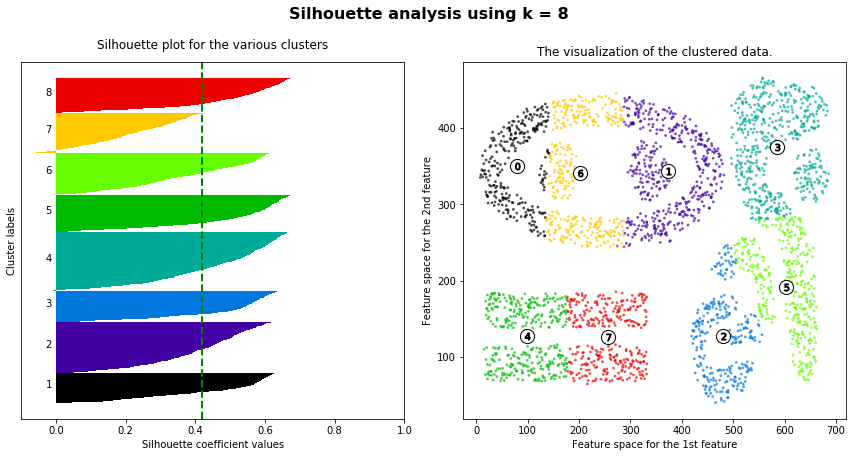

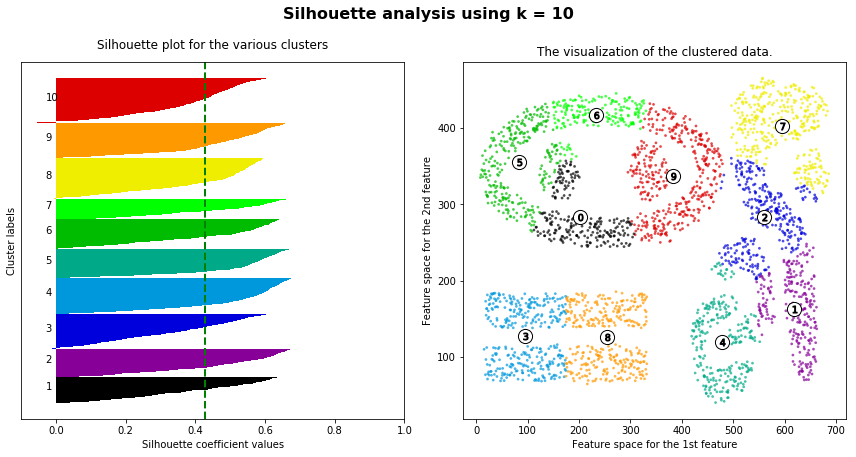

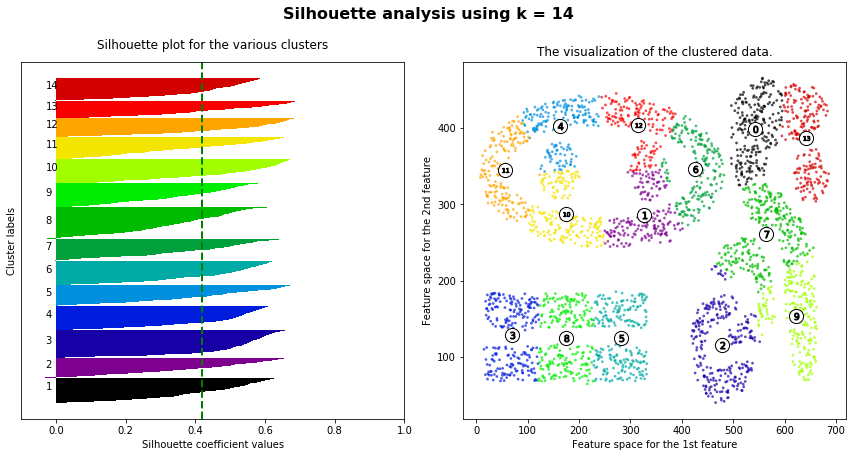

In [19]:
plot_silhouette_coefficient()

# davies bouldinov index
- Meria ako dobre su od seba rozdele zhluky predikcie algoritmov.
- 1 znamena ze lepsie rozdelenie zhkukov

In [20]:
from sklearn.metrics import davies_bouldin_score

print("Davies boulding= " + str(metrics.davies_bouldin_score(np.array(train_df1), k_means)))

Davies boulding= 0.7738582858522713


/Users/edvin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


#### Index sa vypocita ako podobnost priemeru dvoch clusterov

- The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.


-------

## Zalozene na principe ze musia poznat 'ground truth', cize triedu do ktorej patria.

## Rand Score
Is a measure of the similarity between two data clusterings

- TP (True Positive): The object belongs to class positive and we classified it as positive,
- FP (False Positive ): The object belongs to class negative and we classified it as positive,
- TN (True Negative): The object belongs to class negative and we classified it as negative,
- FN (False Negative): The object belongs to class positive but we classified it as negativ


## (TP + TN) / (TP + FP + TN + FN)

In [21]:
y_df = df1[['class']]

Potrebujeme premapovat classu aby bola numerickeho typu 

In [22]:
def preprocess_class(row):
    return int(str(row)[2])

y_df['class'] = y_df['class'].apply(preprocess_class)

/Users/edvin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
# Pretransformujeme dataframe na numpy array
y_df = np.array(y_df['class'])

In [24]:
k_means

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

In [25]:
y_df

array([0, 0, 0, ..., 8, 8, 8])

Ideme vyhodnotit pozorovanie k-meansu na zaklade ground truthu ktory ma dataset a predikovanej hodnoty tohto algoritmu

In [26]:
from sklearn.metrics.cluster import adjusted_rand_score

print(adjusted_rand_score(y_df, k_means))

0.41756257317870715


#### Vracia hodnoty z intervalu [-1, 1] , kde hodnota 0 je povazovana za nahodu

- No assumption is made on the cluster structure: can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

# Homogeneity, completeness
- Homogenity: kazdy zhluk obsahuje iba pozorovania z jednej triedy
- Completeness: prvy z tej istej triedy patria do jedneho zhluku

In [27]:
from sklearn import metrics

print("Homogenity= " + str(metrics.homogeneity_score(y_df, k_means)))
print("Completness= " + str(metrics.completeness_score(y_df, k_means)))

Homogenity= 0.711746306600313
Completness= 0.6279714237237255


Pozrieme co sa stane v pripade tychto vyhodnocovacih metrik pri vacsich k hodnot

In [28]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans

homogenity = []
completness = []
list_k = list(range(2, 50))

for k in list_k:
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(train_df1)
    labels = kmeans_model.labels_
    
    homogenity.append(metrics.homogeneity_score(y_df, labels))
    completness.append(metrics.completeness_score(y_df, labels))
    

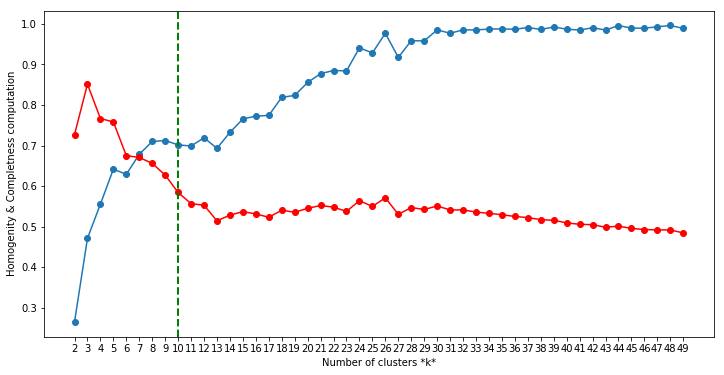

In [29]:
# Plot sse against k
plt.figure(figsize=(12, 6))
plt.plot(list_k, homogenity, '-o')
plt.plot(list_k, completness, '-o', color='red')
plt.xticks(list_k)
plt.axvline(10, linestyle='--', linewidth=2, color='green')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Homogenity & Completness computation');

---

# Meanshift - Image Segmentation

Dobre pouzivany algoritmus na segmentaciu obrazko.

https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/soccer_mean_shift.mp4

In [30]:
from PIL import Image
from matplotlib.pyplot import imshow

In [31]:
def load_and_show_image(name):
    img = Image.open(name)

    image = np.array(img)
    original_shape = image.shape

    fig, ax = plt.subplots(figsize=(15, 17))
    ax.imshow(image, interpolation="nearest")
    
    return original_shape, image

In [32]:
from sklearn.cluster import estimate_bandwidth

def create_segmented_image(org_shape, image, q, samples, shape_1, shape_2):
    X = np.reshape(image, [shape_1, shape_2])
    
    bandwidth = estimate_bandwidth(X, quantile=q, n_samples=samples)
    print("Estimated kernel bandwidth= " + str(bandwidth))
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,n_jobs=5)
    ms.fit(X)

    # Return segmented image pixels
    return np.reshape(ms.labels_, org_shape[:2])

In [33]:
def show_segmented_image(init_image, seg_img):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.imshow(init_image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(seg_img)
    plt.axis('off')
    plt.show()

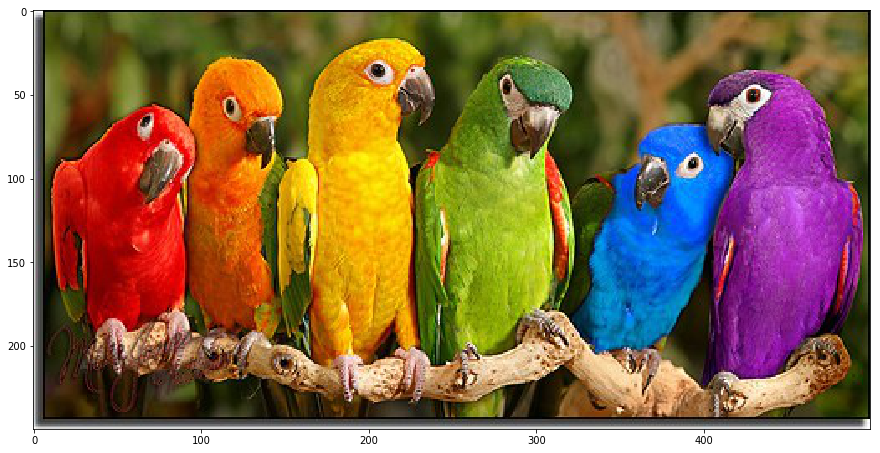

In [34]:
org_shape, image = load_and_show_image('parrots2.jpg')

Vytvorime novy rozsegmentovany obrazok

In [35]:
segmented_image = create_segmented_image(org_shape, image, 0.1, 100, -1, 3)

Estimated kernel bandwidth= 64.50001346613857


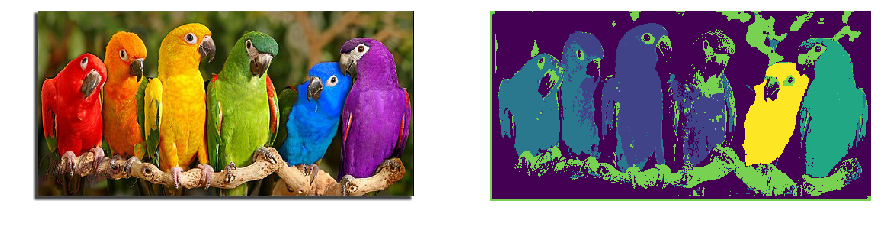

In [36]:
show_segmented_image(image, segmented_image)

### Skusime este dalsi obrazok pretransformovat na segmenty

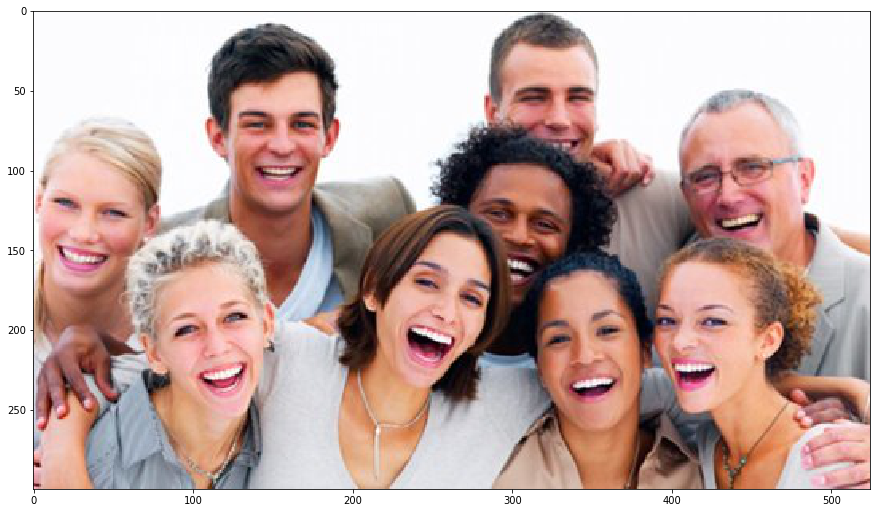

In [37]:
org_shape, image = load_and_show_image('data/ppl_harder.jpg')

In [38]:
segmented_image = create_segmented_image(org_shape, image, 0.2, 100, -1, 3)

Estimated kernel bandwidth= 46.20455550745507


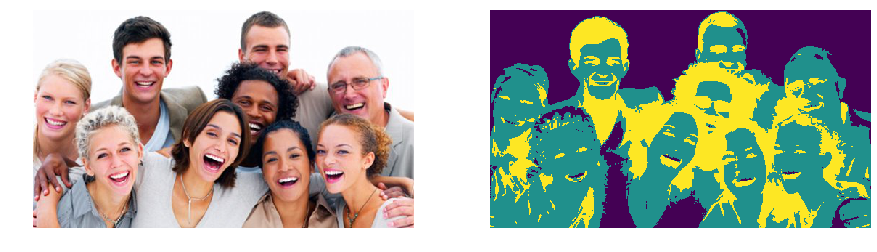

In [39]:
show_segmented_image(image, segmented_image)

----

# DBScan

#### Knee metoda na detekciu najlepsieho eps parametru pre DBScan

In [40]:
from sklearn.neighbors import NearestNeighbors

In [41]:
nbrs = NearestNeighbors(n_neighbors=len(train_df1)).fit(train_df1)

In [42]:
distances, indices = nbrs.kneighbors(train_df1)

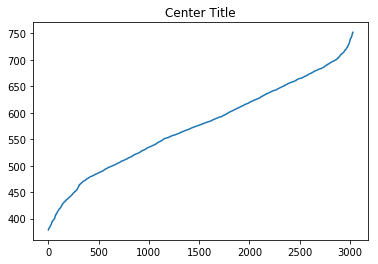

In [43]:
plt.plot(sorted(distances[:, -1]))

plt.title('Center Title')

plt.show()

### OPTICS
-------
This implementation deviates from the original OPTICS by first performing k-nearest-neighborhood searches on all points to identify core sizes, then computing only the distances to unprocessed points when constructing the cluster order. Note that we do not employ a heap to manage the expansion candidates, so the time complexity will be O(n^2).

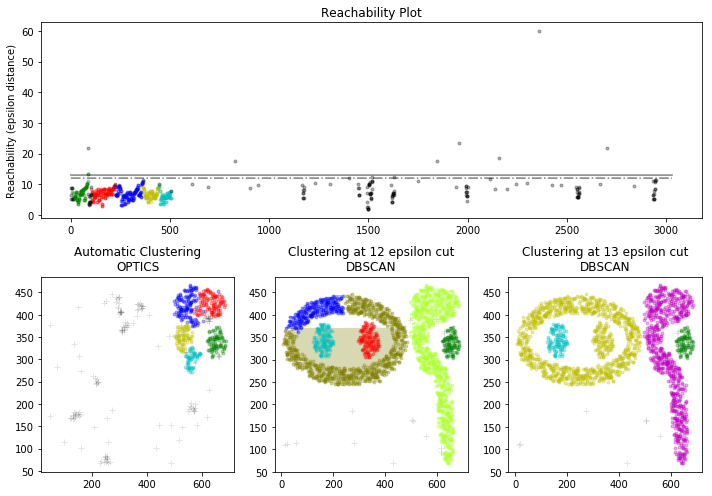

In [36]:
# Authors: Shane Grigsby <refuge@rocktalus.com>
#          Amy X. Zhang <axz@mit.edu>
# License: BSD 3 clause


from sklearn.cluster import OPTICS
import matplotlib.gridspec as gridspec


import numpy as np

import matplotlib.pyplot as plt

# Generate sample data

X = np.array(train_df1)

clust = OPTICS(min_samples=5, rejection_ratio=0.2)

clust.fit(X)

_, labels_12 = clust.extract_dbscan(12)
_, labels_13 = clust.extract_dbscan(13)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
color = ['g.', 'r.', 'b.', 'y.', 'c.']
for k, c in zip(range(0, 5), color):
    Xk = space[labels == k]
    Rk = reachability[labels == k]
    ax1.plot(Xk, Rk, c, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 13, dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 12, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
color = ['g.', 'r.', 'b.', 'y.', 'c.']
for k, c in zip(range(0, 5), color):
    Xk = X[clust.labels_ == k]
    ax2.plot(Xk[:, 0], Xk[:, 1], c, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.25
color = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for k, c in zip(range(0, 6), color):
    Xk = X[labels_12 == k]
    ax3.plot(Xk[:, 0], Xk[:, 1], c, alpha=0.3, marker='.')
ax3.plot(X[labels_12 == -1, 0], X[labels_12 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 12 epsilon cut\nDBSCAN')

# DBSCAN at 0.75
color = ['g.', 'm.', 'y.', 'c.']
for k, c in zip(range(0, 4), color):
    Xk = X[labels_13 == k]
    ax4.plot(Xk[:, 0], Xk[:, 1], c, alpha=0.3)
ax4.plot(X[labels_13 == -1, 0], X[labels_13 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 13 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()